# Homework 9 - Descriptive Notebook

In this homework notebook, we will create and train our own SkipGram embedding, by using the speech from Martin Luther King in the text.text file.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 4th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

In [1]:
# Name: Gabriel koh Kia Kheng
# Student ID: 1003882

### Imports needed

Note, we strongly advise to use a CUDA/GPU machine for this notebook.

Technically, this can be done on CPU only, but it will be very slow!

If you decide to use it on CPU, you might also have to change some of the .cuda() methods used on torch tensors and models in this notebook!

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()
torch.manual_seed(0)

### Step 1. Produce some data based on a given text for training our SkipGram model    

The functions below will be used to produce our dataset for training the SkipGram model.

In [2]:
def text_to_train(text, context_window):
    """
    This function receives the text as a list of words, in lowercase format.
    It then returns data, a list of all the possible (x,y) pairs with
    - x being the middle word of the sentence of length 2*context_window+1,
    - y being a list of 2k words, containing the k preceding words and the k
    posterior words.
    """
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        target = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        input_word = text[i]
        data.append((input_word, target))
        
    return data

In [3]:
def create_text():
    """
    This function loads the string of text from the text.txt file,
    and produces a list of words in string format, as variable text.
    """
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [4]:
text = create_text()

In [5]:
def generate_data(text, context_window):
    """
    This function receives the text and context window size.
    It produces four outputs:
    - vocab, a set containing the words found in text.txt,
    without any doublons,
    - word2index, a dictionary to convert words to their integer index,
    - word2index, a dictionary to convert integer index to their respective words,
    - data, containing our (x,y) pairs for training.
    """
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [6]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [7]:
def words_to_tensor(words: list, word2index: dict, dtype = torch.LongTensor):
    """
    This fucntion converts a word or a list of words into a torch tensor,
    with appropriate format.
    It reuses the word2index dictionary.
    """
    # get indexes of words
    indexes =  [word2index[word] for word in words]
    return Variable(dtype(indexes).cuda())

### Step 2. Create a SkipGram model and train

Task #1: Write your own model for the SkipGram model below.

In [8]:
class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super().__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # regression layers
        for n in range(context_size * 2):
            setattr(self, 'regression_{}'.format(n), nn.Linear(embedding_dim, vocab_size))
            
    def embed(self, inputs):
        # input -> word_index
        word_index = words_to_tensor(inputs, word2index)
        
        # word_index -> embeddings
        embeddings = self.embedding(word_index)
        
        return embeddings

    def forward(self, inputs):
        # inputs -> embeddings
        embeddings = self.embed(inputs)
        
        # embeddings -> logits
        logits = torch.Tensor().cuda()
        for n in range(self.context_size * 2):
            logits = torch.cat((logits, getattr(self, 'regression_{}'.format(n))(embeddings).view(1, self.vocab_size)), dim=0)
    
        return logits

In [11]:
# Create model and pass to CUDA
model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
model = model.cuda()
model.train()

SkipGram(
  (embedding): Embedding(467, 20)
  (regression_0): Linear(in_features=20, out_features=467, bias=True)
  (regression_1): Linear(in_features=20, out_features=467, bias=True)
  (regression_2): Linear(in_features=20, out_features=467, bias=True)
  (regression_3): Linear(in_features=20, out_features=467, bias=True)
)

In [12]:
# Define training parameters
learning_rate = 0.01
epochs = 200
torch.manual_seed(28)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

Task #2: Write your own training function for the SkipGram model in the cell below. It should return a list of losses and accuracies for display later on, along with your trained model. You may also write a helper function for computing the accuracy of your model during training.

In [13]:
from datetime import datetime

def train(data, word2index, model, epochs, loss_func, optimizer, save_loc='skipgram.pt', overwrite=False):
    losses = []
    accuracies = []
    starttime = datetime.now()
    
    for ep in range(epochs):
        now = datetime.now()
        print(f'--------- Epoch {ep + 1} of {epochs} @ {now.strftime("%d-%m-%Y %H:%M:%S")} ---------')

        num_correct = 0
        total = 0
        total_loss = 0
        
        for (word, context) in data:
            # forward pass
            word = [word]
            optimizer.zero_grad()
            output = model(word)

            # calculate loss
            truths = words_to_tensor(context, word2index, torch.LongTensor)
            m = nn.LogSoftmax(dim=1)
            loss = loss_func(m(output), truths)
            total_loss += loss

            # back prop
            loss.backward()
            optimizer.step()

            # get number of correct answers
            num_correct += sum(torch.max(output, dim=1)[1] == truths)
            total += len(context)
    
        # get avg loss
        avg_loss = total_loss/total
        losses.append(avg_loss)
        print('Average Loss: {:.5f}'.format(avg_loss))
        
        # get accuracy 
        accuracy = num_correct/total
        accuracies.append(accuracy)
        print('Accuracy: {:.5f}, {}/{}\n'.format(accuracy, num_correct, total))

        # save model
        if overwrite:
            torch.save(model.state_dict(), save_loc)
        
    # print the time taken
    endtime = datetime.now()
    print('--------- Training completed ---------')
    time_elapsed = (endtime - starttime).seconds
    hours, remainder = divmod(time_elapsed, 3600)
    minutes, seconds = divmod(time_elapsed, 60)
    print('Time taken: {:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds)))
    
    return losses, accuracies, model

overwrite = False # ONLY SET THIS TO TRUE TO OVERWRITE CURRENT MODEL!
losses, accuracies, model = train(data, word2index, model, epochs, loss_function, optimizer, overwrite=overwrite)

--------- Epoch 1 of 200 @ 04-04-2021 02:27:34 ---------
Average Loss: 1.56902
Accuracy: 0.00391, 22/5620

--------- Epoch 2 of 200 @ 04-04-2021 02:27:39 ---------
Average Loss: 1.52326
Accuracy: 0.02616, 147/5620

--------- Epoch 3 of 200 @ 04-04-2021 02:27:43 ---------
Average Loss: 1.48259
Accuracy: 0.05196, 292/5620

--------- Epoch 4 of 200 @ 04-04-2021 02:27:48 ---------
Average Loss: 1.44573
Accuracy: 0.07527, 423/5620

--------- Epoch 5 of 200 @ 04-04-2021 02:27:52 ---------
Average Loss: 1.41192
Accuracy: 0.09751, 548/5620

--------- Epoch 6 of 200 @ 04-04-2021 02:27:56 ---------
Average Loss: 1.38077
Accuracy: 0.11281, 634/5620

--------- Epoch 7 of 200 @ 04-04-2021 02:28:01 ---------
Average Loss: 1.35209
Accuracy: 0.12224, 687/5620

--------- Epoch 8 of 200 @ 04-04-2021 02:28:05 ---------
Average Loss: 1.32577
Accuracy: 0.13096, 736/5620

--------- Epoch 9 of 200 @ 04-04-2021 02:28:09 ---------
Average Loss: 1.30167
Accuracy: 0.13915, 782/5620

--------- Epoch 10 of 200 @ 0

Average Loss: 0.80159
Accuracy: 0.24626, 1384/5620

--------- Epoch 77 of 200 @ 04-04-2021 02:32:26 ---------
Average Loss: 0.79835
Accuracy: 0.24715, 1389/5620

--------- Epoch 78 of 200 @ 04-04-2021 02:32:32 ---------
Average Loss: 0.79515
Accuracy: 0.24822, 1395/5620

--------- Epoch 79 of 200 @ 04-04-2021 02:32:36 ---------
Average Loss: 0.79200
Accuracy: 0.25000, 1405/5620

--------- Epoch 80 of 200 @ 04-04-2021 02:32:40 ---------
Average Loss: 0.78889
Accuracy: 0.25214, 1417/5620

--------- Epoch 81 of 200 @ 04-04-2021 02:32:43 ---------
Average Loss: 0.78582
Accuracy: 0.25391, 1427/5620

--------- Epoch 82 of 200 @ 04-04-2021 02:32:47 ---------
Average Loss: 0.78280
Accuracy: 0.25409, 1428/5620

--------- Epoch 83 of 200 @ 04-04-2021 02:32:51 ---------
Average Loss: 0.77982
Accuracy: 0.25569, 1437/5620

--------- Epoch 84 of 200 @ 04-04-2021 02:32:54 ---------
Average Loss: 0.77687
Accuracy: 0.25623, 1440/5620

--------- Epoch 85 of 200 @ 04-04-2021 02:32:58 ---------
Average Lo

Average Loss: 0.63973
Accuracy: 0.32633, 1834/5620

--------- Epoch 152 of 200 @ 04-04-2021 02:38:03 ---------
Average Loss: 0.63828
Accuracy: 0.32669, 1836/5620

--------- Epoch 153 of 200 @ 04-04-2021 02:38:07 ---------
Average Loss: 0.63685
Accuracy: 0.32811, 1844/5620

--------- Epoch 154 of 200 @ 04-04-2021 02:38:11 ---------
Average Loss: 0.63543
Accuracy: 0.32865, 1847/5620

--------- Epoch 155 of 200 @ 04-04-2021 02:38:16 ---------
Average Loss: 0.63402
Accuracy: 0.32989, 1854/5620

--------- Epoch 156 of 200 @ 04-04-2021 02:38:19 ---------
Average Loss: 0.63263
Accuracy: 0.33060, 1858/5620

--------- Epoch 157 of 200 @ 04-04-2021 02:38:23 ---------
Average Loss: 0.63124
Accuracy: 0.33221, 1867/5620

--------- Epoch 158 of 200 @ 04-04-2021 02:38:26 ---------
Average Loss: 0.62987
Accuracy: 0.33399, 1877/5620

--------- Epoch 159 of 200 @ 04-04-2021 02:38:30 ---------
Average Loss: 0.62851
Accuracy: 0.33523, 1884/5620

--------- Epoch 160 of 200 @ 04-04-2021 02:38:34 ---------
A

### 3. Visualization

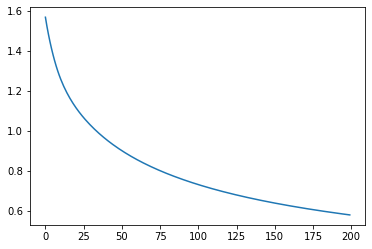

In [14]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

In [15]:
# Display accuracies over time
plt.figure()
plt.plot(accuracies)
plt.show()

### Questions and expected answers for the report

A. Copy and paste your SkipGram class code (Task #1 in the notebook)

B. Copy and paste your train function (Task #2 in the notebook), along with any helper functions you might have used (e.g. a function to compute the accuracy of your model after each iteration). Please also copy and paste the function call with the parameters you used for the train() function.

C. Why is the SkipGram model much more difficult to train than the CBoW. Is it problematic if it does not reach a 100% accuracy on the task it is being trained on?

D. If we were to evaluate this model by using intrinsic methods, what could be a possible approach to do so. Please submit some code that will demonstrate the performance/problems of the word embedding you have trained!

##### A. Copy and paste your SkipGram class code (Task #1 in the notebook)

In [9]:
class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super().__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # regression layers
        for n in range(context_size * 2):
            setattr(self, 'regression_{}'.format(n), nn.Linear(embedding_dim, vocab_size))
            
    def embed(self, inputs):
        # input -> word_index
        word_index = words_to_tensor(inputs, word2index)
        
        # word_index -> embeddings
        embeddings = self.embedding(word_index)
        
        return embeddings

    def forward(self, inputs):
        # inputs -> embeddings
        embeddings = self.embed(inputs)
        
        # embeddings -> logits
        logits = torch.Tensor().cuda()
        for n in range(self.context_size * 2):
            logits = torch.cat((logits, getattr(self, 'regression_{}'.format(n))(embeddings).view(1, self.vocab_size)), dim=0)
    
        return logits

##### B. Copy and paste your train function (Task #2 in the notebook), along with any helper functions you might have used (e.g. a function to compute the accuracy of your model after each iteration). Please also copy and paste the function call with the parameters you used for the train() function.

In [17]:
def train(data, word2index, model, epochs, loss_func, optimizer, save_loc='skipgram.pt', overwrite=False):
    losses = []
    accuracies = []
    starttime = datetime.now()
    
    for ep in range(epochs):
        now = datetime.now()
        print(f'--------- Epoch {ep + 1} of {epochs} @ {now.strftime("%d-%m-%Y %H:%M:%S")} ---------')

        num_correct = 0
        total = 0
        total_loss = 0
        
        for (word, context) in data:
            # forward pass
            word = [word]
            optimizer.zero_grad()
            output = model(word)

            # calculate loss
            truths = words_to_tensor(context, word2index, torch.LongTensor)
            m = nn.LogSoftmax(dim=1)
            loss = loss_func(m(output), truths)
            total_loss += loss

            # back prop
            loss.backward()
            optimizer.step()

            # get number of correct answers
            num_correct += sum(torch.max(output, dim=1)[1] == truths)
            total += len(context)
    
        # get avg loss
        avg_loss = total_loss/total
        losses.append(avg_loss)
        print('Average Loss: {:.5f}'.format(avg_loss))
        
        # get accuracy 
        accuracy = num_correct/total
        accuracies.append(accuracy)
        print('Accuracy: {:.5f}, {}/{}\n'.format(accuracy, num_correct, total))

        # save model
        if overwrite:
            torch.save(model.state_dict(), save_loc)
        
    # print the time taken
    endtime = datetime.now()
    print('--------- Training completed ---------')
    time_elapsed = (endtime - starttime).seconds
    hours, remainder = divmod(time_elapsed, 3600)
    minutes, seconds = divmod(time_elapsed, 60)
    print('Time taken: {:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds)))
    
    return losses, accuracies, model

##### C. Why is the SkipGram model much more difficult to train than the CBoW. Is it problematic if it does not reach a 100% accuracy on the task it is being trained on?

One of the reasons why the SkipGram model is more difficult to train that the CBoW is because the same word could have a different set of context words at different points of the corpus. Even if the model can predict the correct context words the first time it encounters a word, it may not get them right the next time it encounters the same word, even though it predicts the first set of context words. This would mean that it is almost impossible for the model to get 100% accuracy and 0 loss. On the contrary, the training of CBoW involves using context words to predict the word in the middle. The context words are almost unique at every occurence to predict the middle word. Thus, the accuracy and loss values can hypothetically reach a 100% and 0 respectively.

Nevertheless, it is not an issue if the model does not achieve a 100% accuracy for both tasks. The main objective of training these 2 models are to obtain a function that can convert input words as a one hot vector to a dense representation, while accounting for the semantics of the words. By training on the respective tasks, the embedding layer of the model may improve regardless of the accuracy or the loss on the task. However, to actually determine if the embedding layer has improved in transforming the inputs into a dense representation, we would have to test it on other tasks that we want to use the embeddings on.



##### D. If we were to evaluate this model by using intrinsic methods, what could be a possible approach to do so. Please submit some code that will demonstrate the performance/problems of the word embedding you have trained!

We can use our understanding on relation between english words to test if the model draws the same relation. For example:
- Words like 'boy' and 'man' should have similiar embeddings, therefore should have a small cosine and euclidean distance
- The vectors connecting 'queen' and 'girl' should be simliar to that between 'king' and 'boy', therefore should have a small cosine and euclidean distance as well 

Some of these words in the above example are not in the corpus. But you get the idea. The following code will exemplify the above test cases using words in the corpus.

On top of that, we can plot the tSNE and PCA representation of the vector representations. Since the embedding vectors only have a dimensionality of 20, PCA would be sufficient. In both cases, simliar words should be close together on the plot.

In [9]:
# load model
# model_loc = 'skipgram.pt'
model_loc = 'skipgram_200eps_0.01lr.pt'
model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
model.load_state_dict(torch.load(model_loc))
model.cuda()
model.eval()

SkipGram(
  (embedding): Embedding(467, 20)
  (regression_0): Linear(in_features=20, out_features=467, bias=True)
  (regression_1): Linear(in_features=20, out_features=467, bias=True)
  (regression_2): Linear(in_features=20, out_features=467, bias=True)
  (regression_3): Linear(in_features=20, out_features=467, bias=True)
)

###### Distances between similar and different words

In [10]:
# init cosine similarity and pairwise distance functions
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
pdist = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=False)

# get scores for 'boys' and 'girls'
words = ['boys', 'girls']
embeddings = [model.embed([word]).view(1,-1) for word in words]
cos_similarity = cos(embeddings[0], embeddings[1])
euclid_distance = pdist(embeddings[0], embeddings[1])
print('For the words {}:'.format(' and '.join(words)))
print('\tCosine similarity = {:.5f}'.format(cos_similarity[0]))
print('\tEuclidean distance = {:.5f}'.format(euclid_distance[0]))

# get scores for 'brothers' and 'sisters'
words = ['brothers', 'sisters']
embeddings = [model.embed([word]).view(1,-1) for word in words]
cos_similarity = cos(embeddings[0], embeddings[1])
euclid_distance = pdist(embeddings[0], embeddings[1])
print('\nFor the words {}:'.format(' and '.join(words)))
print('\tCosine similarity = {:.5f}'.format(cos_similarity[0]))
print('\tEuclidean distance = {:.5f}'.format(euclid_distance[0]))

# get scores for 'satisfied' and 'words'
words = ['note', 'tranquility']
embeddings = [model.embed([word]).view(1,-1) for word in words]
cos_similarity = cos(embeddings[0], embeddings[1])
euclid_distance = pdist(embeddings[0], embeddings[1])
print('\nFor the words "{}":'.format('" and "'.join(words)))
print('\tCosine similarity = {:.5f}'.format(cos_similarity[0]))
print('\tEuclidean distance = {:.5f}'.format(euclid_distance[0]))

For the words boys and girls:
	Cosine similarity = 0.05325
	Euclidean distance = 7.27095

For the words brothers and sisters:
	Cosine similarity = 0.10301
	Euclidean distance = 6.98592

For the words "note" and "tranquility":
	Cosine similarity = 0.13173
	Euclidean distance = 5.36741


A cosine simliarity value of 1 means the angular distance between the words are the same. On the other hand, a euclidean distance of 0 means that embeddings 0 units apart in the hyperspace.

'boys' and 'girls' are genders, so they should have somewhat similar embeddings.
'satisfied' and 'words' are words that have no correlation with each other, a good representation should return a low cosine similarity and high euclidean distance. 



###### Distances between word relations vectors

In [11]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
pdist = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=False)

# get scores for vector 'boys'->'brothers' and 'girls'->'sisters'
pairs = [['boys', 'brothers'], ['girls', 'sisters']]
embeddings = [[model.embed([word]).view(1,-1) for word in words] for words in pairs]
distances = [d[0] - d[1] for d in embeddings]
cos_similarity = cos(distances[0], distances[1])
euclid_distance = pdist(distances[0], distances[1])
print('For the vector representations of the word relations ["{}" -> "{}"] and ["{}" -> "{}"]:'.format(pairs[0][0], pairs[0][1], pairs[1][0], pairs[1][1]))
print('\tCosine similarity = {:.5f}'.format(cos_similarity[0]))
print('\tEuclidean distance = {:.5f}'.format(euclid_distance[0]))

# get scores for vector 'color'->'white' and 'country'->'america'
pairs = [['color', 'white'], ['country', 'america']]
embeddings = [[model.embed([word]).view(1,-1) for word in words] for words in pairs]
distances = [d[0] - d[1] for d in embeddings]
cos_similarity = cos(distances[0], distances[1])
euclid_distance = pdist(distances[0], distances[1])
print('\nFor the vector representations of the word relations ["{}" -> "{}"] and ["{}" -> "{}"]:'.format(pairs[0][0], pairs[0][1], pairs[1][0], pairs[1][1]))
print('\tCosine similarity = {:.5f}'.format(cos_similarity[0]))
print('\tEuclidean distance = {:.5f}'.format(euclid_distance[0]))

For the vector representations of the word relations ["boys" -> "brothers"] and ["girls" -> "sisters"]:
	Cosine similarity = 0.35216
	Euclidean distance = 8.16018

For the vector representations of the word relations ["color" -> "white"] and ["country" -> "america"]:
	Cosine similarity = 0.20891
	Euclidean distance = 10.53611


The *sibling form* of 'boys' is 'brothers' and 'girls' is a 'sisters'. Thus the relation between the words in each pair should be similiar. The vector between the pairs of embeddings should have high cosine similarity and low euclidean distance.

'white' is a 'color' and 'america' is a 'country'. This 'is a' relation between the words in each pair should be similiar. The vector between the pairs of embeddings should have high cosine similarity and low euclidean distance. 

###### Dimensionality reduction - PCA plot

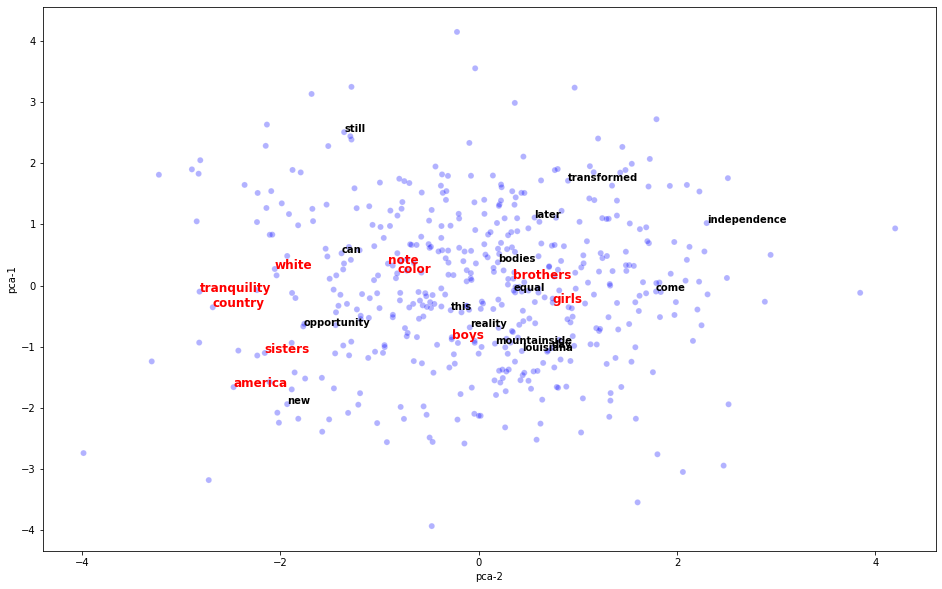

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# get embeddings for all words in vocab
embeddings = np.array([model.embed([word]).flatten().cpu().detach().numpy() for word in vocab])

# apply PCA
n_components = 3
pca = PCA(n_components=n_components)
pca_results = pca.fit_transform(embeddings)

# put pca results in df
df = pd.DataFrame(pca_results, columns=['pca-{}'.format(n+1) for n in range(n_components)])
df['y'] = vocab

# axes
x_ax = 'pca-2'
y_ax = 'pca-1'

# plot scatterplot
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=x_ax, y=y_ax,
    hue="y",
    data=df,
    legend=False,
    alpha=.3,
    palette=['blue' for n in vocab]
)
# ax.set_ylim([-2e-13,2e-13]) # scale the plot to spread out majority of the plots

def insert_text(df, ax, x_ax, y_ax, fontsize='medium', fontweight='demi', c='black'):
    '''
    inserts the word at position x=pca-1, y=pca-2 into the scatter plot
    '''
    for i, point in df.iterrows():
        ax.text(point[x_ax], point[y_ax], str(point['y']), fontsize=fontsize, fontweight=fontweight, c=c)
        
def random_label_point(df, ax, x_ax, y_ax, n=15):
    '''
    insert n random words into the plot
    '''
    df = df.sample(n=n, random_state=10)
    insert_text(df, ax, x_ax, y_ax)
        
def selected_label_point(df, ax, x_ax, y_ax, selected_words):
    '''
    insert the selected words into the plot
    '''
    df = df[df['y'].isin(selected_words)]
    insert_text(df, ax, x_ax, y_ax, c='red', fontsize='large')

# plot some selected words as well as some random words
selected_words = ['boys', 'girls', 'sisters', 'brothers', 'color', 'white', 'country', 'america', 'note', 'tranquility']
selected_label_point(df, plt.gca(), x_ax, y_ax, selected_words)
random_label_point(df, plt.gca(), x_ax, y_ax)

After using PCA to do dimensionality reduction, we can plot the coordinates on a 2d scatterplot.Each point on the scatterplot represents the vector representation of words in the vocabulary. For the sake of readability, I have randomly selected 15 words to be written on the plot in black. I have also selected 10 words, which are those that we used to do comparison in the previous code blocks. These selected words are displayed in red font. 

Based on our human understanding of the english language, words with similar meanings or semantics should be represented similarly on the plot. Some of the relations we mentioned before can be seen from this plot. For example:
- Vector representations of 'boys' and 'girls'
- The vector 'boys' -> 'brothers'compared to 'girls' -> 'sisters'

Ultimately, from this plot, we can have a rough gage of how well the embedding is able to represent the words as vectors in hyperspace.